# Tutorial

In [3]:
# enable auto reload
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os

## 1. Preprocessed 데이터 로드

In [5]:
RAW_PATH = './data'            # path to raw data
NP_PATH = './preprocessed'     # path to preprocessed data
FRAME_LEN = 1024               # length of one data frame
FRAME_INTV = 512               # interval between data frames

In [6]:
if not os.path.exists(NP_PATH):
    os.mkdir(NP_PATH)

In [7]:
from src.utils.data_utils import get_preprocessed_data

DATA, train_idx, test_idx, trainY, testY, train_diameter, test_diameter, train_rpm, test_rpm = get_preprocessed_data(RAW_PATH, NP_PATH, FRAME_LEN, FRAME_INTV)

### 데이터 설명
- **DATA** :  하나로 합쳐진 베어링 데이터의 총 구간 *(total_length, 1)*
    
- **train_idx / test_idx** : train/test 데이터셋의 각 프레임 시작 위치 *(dataset_size,)*

- **trainY / testY** : train/test 데이터셋의 True Label *(dataset_size,)*
    
- **train_diameter / test_diameter** : train/test 데이터셋의 파괴 직경 *(dataset_size,)*


<img src="resources/data.png" width="500">


## 2. 데이터 이해하기

***<DataAnalysis.ipynb>에서 직접 다양하게 실행해볼 수 있습니다.***

*전체 데이터 구간 확인*

<IPython.core.display.Javascript object>


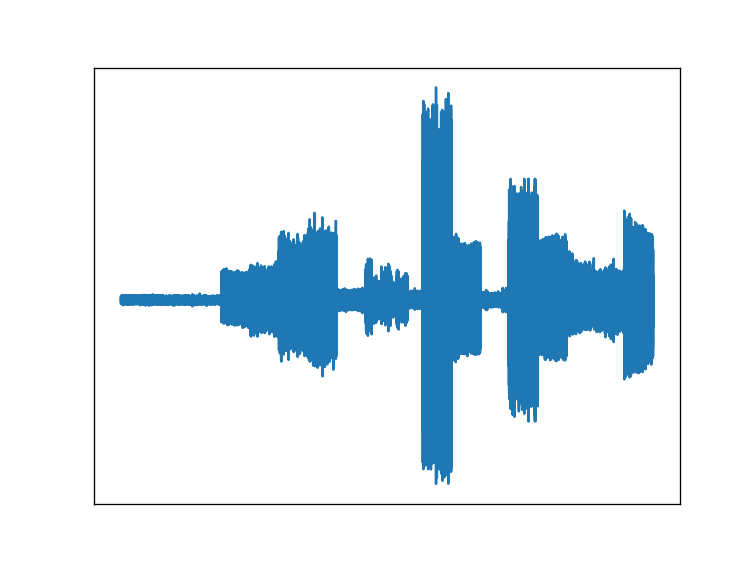

In [8]:
%matplotlib notebook
plt.xticks([])
plt.yticks([])
plt.plot(DATA)
plt.show()

*train 데이터셋의 I번째 데이터(I번째 프레임) 확인*

<IPython.core.display.Javascript object>


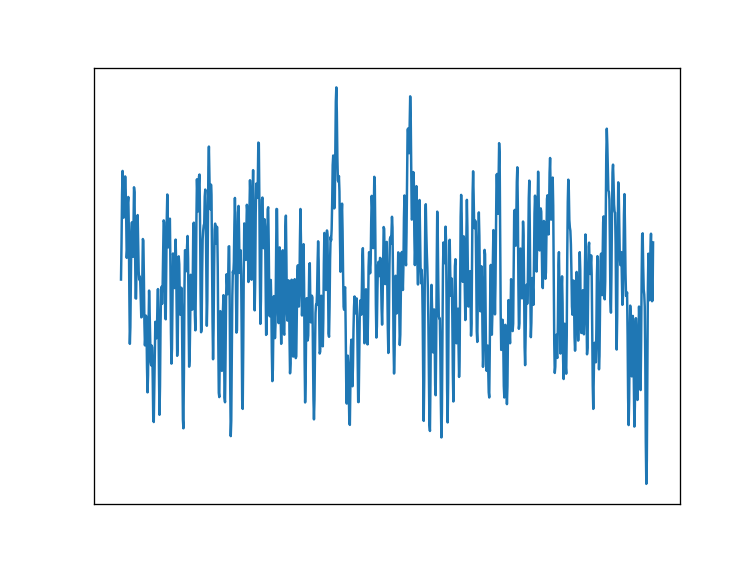

In [9]:
%matplotlib notebook
I = 0
plt.xticks([])
plt.yticks([])
plt.plot(DATA[train_idx[I]:train_idx[I]+FRAME_LEN])
plt.show()

*test 데이터셋의 I번째 데이터(I번째 프레임) 확인*

<IPython.core.display.Javascript object>


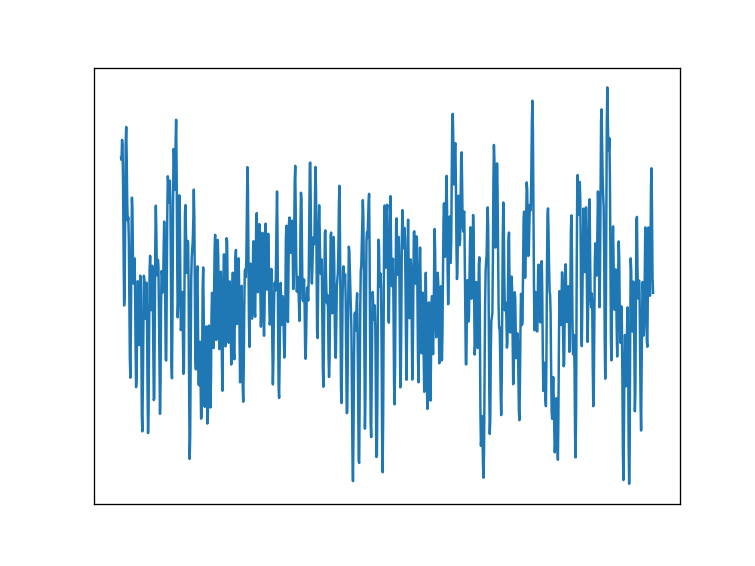

In [10]:
%matplotlib notebook
I = 0
plt.xticks([])
plt.yticks([])
plt.plot(DATA[test_idx[I]:test_idx[I]+FRAME_LEN])
plt.show()

*각 Label의 I번째 데이터(I번째 프레임) 확인*

<IPython.core.display.Javascript object>


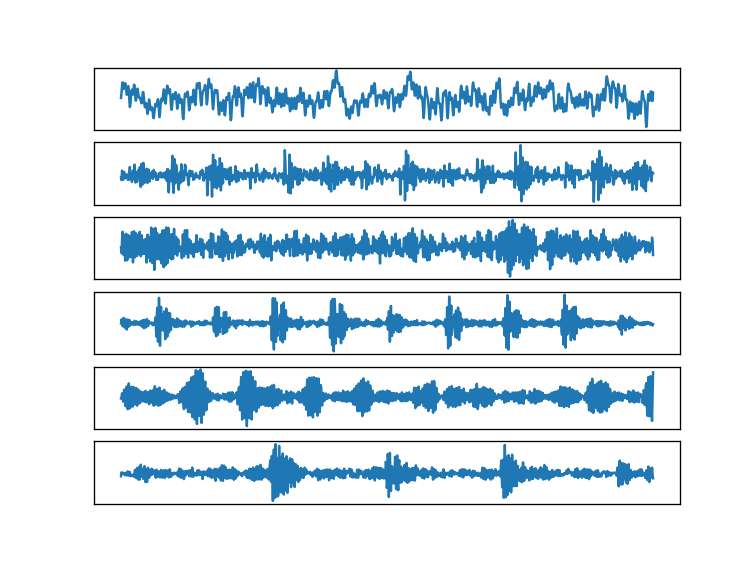

In [11]:
%matplotlib notebook
I = 0
for y in range(6):
    idx_labeled_y = train_idx[trainY==y]
    ax = plt.subplot(6,1,y+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.plot(DATA[idx_labeled_y[I]:idx_labeled_y[I]+FRAME_LEN])
plt.show()

*Label y를 가진 I번째 데이터 확인*

- label = 0, diameters = [0]
- label = 1/2, diameters = [1,2,3,4]
- label = 3, diameters = [1,2,3]
- label = 4/5, diameters = [1,3]

<IPython.core.display.Javascript object>


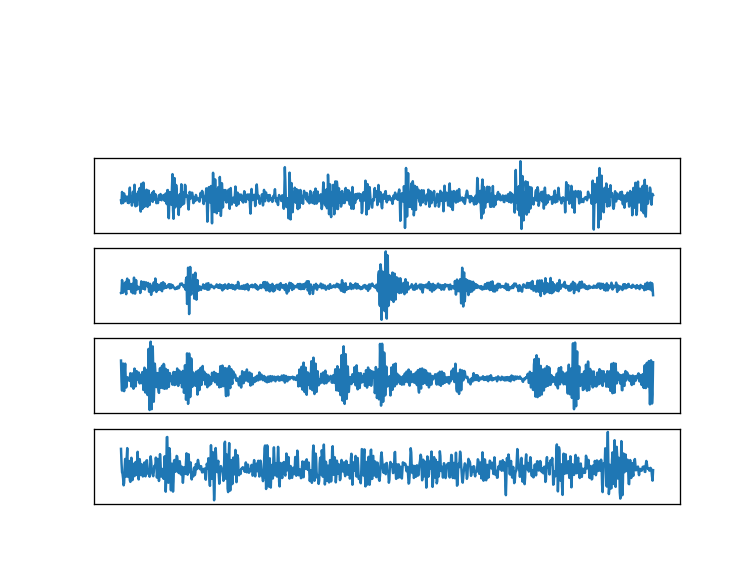

In [12]:
%matplotlib notebook
I=0
y=1
for d in range(1,5):
    idx_diameter_d = train_idx[(trainY==y)&(train_diameter==d)]
    ax = plt.subplot(5,1,d+1)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.plot(DATA[idx_diameter_d[I]:idx_diameter_d[I]+FRAME_LEN])
plt.show()

*모든 (frame, label, fault diameter) 조합의 I번째 프레임 확인*

<IPython.core.display.Javascript object>


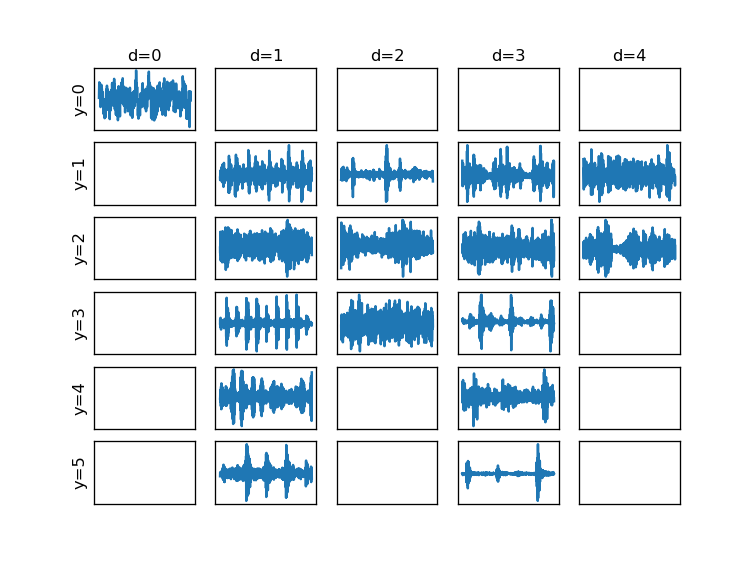

In [13]:
%matplotlib notebook
I = 0
for y in range(6):
    for d in range(5):
        ax = plt.subplot(6,5,5*y+d+1)
        if y==0:
            ax.set_xlabel('d=%d'%d)
            ax.xaxis.set_label_position('top')
        if d==0:
            ax.set_ylabel('y=%d'%y)
        ax.set_xticks([])
        ax.set_yticks([])
        idx_oi = train_idx[(trainY==y)&(train_diameter==d)]
        if idx_oi.shape[0]==0:
            continue
        ax.plot(DATA[idx_oi[I]:idx_oi[I]+FRAME_LEN])
    
plt.show()

## 3. Supervised Learning!!!

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import time

In [15]:
SEED=0
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=True

### 3.1 Model Definition
simple model

In [16]:
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.enc_layer1 = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        self.enc_layer2 = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        self.enc_layer3 = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        self.enc_layer4 = nn.Sequential(
            nn.Conv1d(32, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Dropout(p=0.3)
        )
        
        self.classifier1 = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU()
        )
        self.classifier2 = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU()
        )
        self.classifier3 = nn.Linear(32, 6)
        
        self.apply(self.init_weights)
        
    def init_weights(self, m):
        if type(m)==nn.Linear or type(m)==nn.Conv1d:
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
    
    def forward(self, x, get_latent=False):
        x = self.enc_layer1(x)
        x = self.enc_layer2(x)
        x = self.enc_layer3(x)
        x = self.enc_layer4(x)
        
        x = x.mean(dim=-1)
        z = x
        
        x = self.classifier1(x)        
        x = self.classifier2(x)     
        x = self.classifier3(x)
        
        if get_latent:
            return x,z
        else:
            return x
    

### 3.2 Train Configurations

train & get the score

In [17]:
LR = 1e-3
BATCH = 128
EPOCH = 500
TOL = 10
SAVE_PATH = './saved_models'
SAV_INTV = 10
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

In [18]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [19]:
model = SimpleModel()
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [20]:
train_shuffle = np.arange(train_idx.shape[0])
np.random.shuffle(train_shuffle)
train_shuffle, val_shuffle = np.split(train_shuffle, [4*train_shuffle.shape[0]//5])
print(train_idx.shape, train_shuffle.shape, val_shuffle.shape)

(13966,) (11172,) (2794,)


### 3.3 Training Functions
Implemented in the source

In [21]:
def batch_step(model, X, Y, M=None, train=False, optimizer=None):
    if M is None:
        M = torch.zeros_like(Y) == 0
        M = M.to(device=X.device, dtype=torch.bool)
    p = model(X)
    
    pred = torch.argmax(p, dim=1)
    
    
    class_loss = torch.tensor(0.0).to(device=X.device)
    if M.any():
        class_loss += nn.CrossEntropyLoss()(p[M],Y[M])

        if train:
            class_loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
    return class_loss, pred

In [22]:
def epoch_step(model, data_idx, dataY, data, train=False, shuffle=None, mask=None, optimizer=None, batch_step=batch_step, device=None,batch=128,frame_len=1024):
    if shuffle is None:
        shuffle = np.arange(data_idx.shape[0])
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    avg_loss = 0.0
    n = 0
    n_correct = 0
    n_wrong = 0
    for b in range((shuffle.shape[0]-1)//batch+1):
        X = data[data_idx[shuffle[b*batch:(b+1)*batch]][:,None]+np.arange(frame_len)]
        Y = dataY[shuffle[b*batch:(b+1)*batch]]
        X = np.transpose(X, [0,2,1])
        X = torch.tensor(X, device=device, dtype=torch.float)
        Y = torch.tensor(Y, device=device, dtype=torch.long)
        Yall = Y.clone()
        if mask is None:
            M = None
        else:
            M = mask[shuffle[b*batch:(b+1)*batch]]
            M = torch.tensor(M, device=device, dtype=torch.bool)
            Y[~M]=0
        loss, pred = batch_step(model, X, Y, train=train, optimizer=optimizer, M=M)
        correct = (Yall[Yall==pred]).shape[0]
        wrong = (Yall[Yall!=pred]).shape[0]
        avg_loss = (avg_loss*n + loss.item()*X.shape[0])/(n+X.shape[0])
        n += X.shape[0]
        n_correct += correct
        n_wrong += wrong
    return avg_loss, n_correct/(n_correct+n_wrong)

def train(model, optimizer, train_idx, trainY, data, model_name, train_shuffle, val_shuffle, mask=None, batch_step=batch_step, sav_intv=10, tol=10, sav_path = './', device=None, epoch=500, batch=128,frame_len=1024):
    best_eval = float('inf')
    for e in range(epoch):
        timestamp = time.time()
        
        model.train()
        train_loss, train_acc = epoch_step(model, train_idx, trainY, data, train=True, optimizer=optimizer, shuffle=train_shuffle, mask=mask, device=device, batch=batch,frame_len=frame_len,batch_step=batch_step)
        model.eval()
        with torch.no_grad():
            eval_loss, eval_acc = epoch_step(model, train_idx, trainY, data, train=False, shuffle=val_shuffle, mask=mask, device=device, batch=batch,frame_len=frame_len,batch_step=batch_step)
        
        print('(%.2fs)[Epoch %d]'%(time.time()-timestamp, e+1))
        print('\t(train) loss : %.5f,\tacc : %.5f'%(train_loss, train_acc))
        print('\t(eval) loss : %.5f,\tacc : %.5f'%(eval_loss, eval_acc))
        
        if eval_loss < best_eval:
            best_eval = eval_loss
            patience = 0
            torch.save(model.state_dict(), '%s/%s_best.pth'%(sav_path, model_name))
        if e%sav_intv == sav_intv-1:
            torch.save(model.state_dict(), '%s/%s_e%d.pth'%(sav_path, model_name, e+1))
        patience += 1
        if patience > tol:
            print('Early stop at Epoch %d'%(e+1))
            break

### 3.4 Start Training

In [23]:
TRAIN_PARAMS = {
    'model' : model,
    'optimizer' : optimizer,
    'train_idx' : train_idx,
    'trainY' : trainY,
    'data' : DATA,
    'model_name' : 'tutorial_supervised',
    'train_shuffle' : train_shuffle,
    'val_shuffle' : val_shuffle,
    'mask' : None,
    'sav_intv' : SAV_INTV,
    'tol' : TOL,
    'sav_path' : SAVE_PATH,
    'epoch' : EPOCH,
    'batch' : BATCH,
    'frame_len' : FRAME_LEN,
    'batch_step' : batch_step
}

In [22]:
train(**TRAIN_PARAMS)

(5.61s)[Epoch 1]
	(train) loss : 1.63021,	acc : 0.29860
	(eval) loss : 1.46837,	acc : 0.34538


KeyboardInterrupt: 

### 3.5 Testing

In [24]:
def test(model, test_idx, testY, data, model_name, batch_step=batch_step, sav_path = './', device=None, batch=128,frame_len=1024, load_version='best'):
    timestamp = time.time()
    
    model.load_state_dict(torch.load('%s/%s_%s.pth'%(sav_path, model_name, load_version)))
    
    model.eval()
    with torch.no_grad():
        loss, acc = epoch_step(model, test_idx, testY, data, train=False, device=device, batch=batch,frame_len=frame_len,batch_step=batch_step)

    print('Test Result of model <%s>:%s'%(model_name, load_version))
    print('  [Loss]\t%.5f'%(loss))
    print('  [Accuracy]\t%.2f%%'%(acc*100))
    

In [25]:
TEST_PARAMS = {
    'model' : model,
    'test_idx' : test_idx,
    'testY' : testY,
    'data' : DATA,
    'model_name' : 'tutorial_supervised',
    'load_version' : 'best',
    'sav_path' : SAVE_PATH,
    'batch' : BATCH,
    'frame_len' : FRAME_LEN,
    'batch_step' : batch_step
}

In [25]:
test(**TEST_PARAMS)

Test Result of model <tutorial_supervised>:best
  [Loss]	1.47227
  [Accuracy]	34.47%


In [26]:
from src.experiment import score_table
score_table(diameter = test_diameter, **TEST_PARAMS)



		0	1	2	3	4	5	| total
0"	|	1.0	-	-	-	-	-	| 1.0
0.007"	|	-	0.329	0.192	0.0	0.0	0.0	| 0.104
0.14"	|	-	0.843	0.125	0.0	-	-	| 0.322
0.021"	|	-	0.098	0.052	0.265	0.0	0.0	| 0.083
0.028"	|	-	0.005	1.0	-	-	-	| 0.5
------------------------------------------------------------------------
total	|	1.0	0.319	0.339	0.088	0.0	0.0	| 0.344


<IPython.core.display.Javascript object>


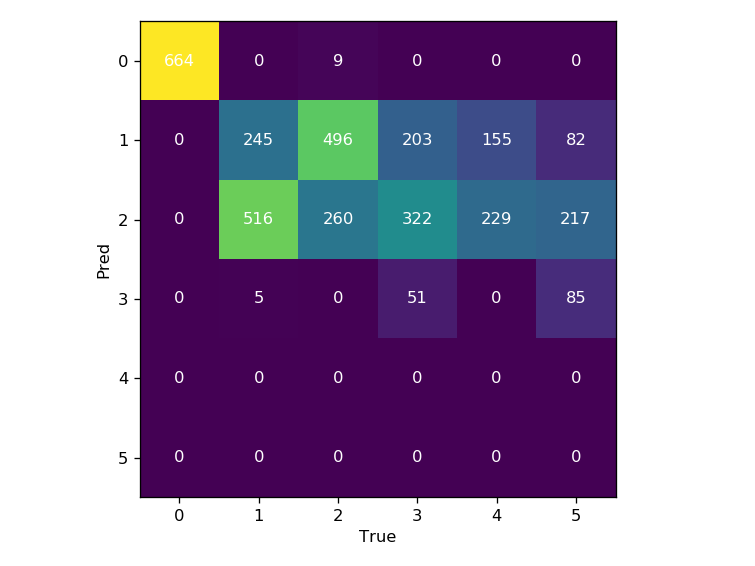

In [27]:
from src.experiment import confusion_matrix
%matplotlib notebook

confusion_matrix(**TEST_PARAMS)

### 3.6 Latent Vector Analysis
plot tsne color according to true y, prediction, diameter, rpm
you can do yourself on RepresentationAnalysis.ipynb

In [28]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from src.experiment import get_latents

In [29]:
z, preds = get_latents(**TEST_PARAMS)
z = z.cpu().numpy()
preds = preds.cpu().numpy()
print(z.shape, preds.shape)

(3539, 32) (3539,)


In [30]:
tsne = TSNE(n_components=2)
z_tsne = tsne.fit_transform(z)
print(z_tsne.shape)

(3539, 2)


In [31]:
def draw_plot(tsne, label, cmap = None, legend = False, ax=None):
    if ax is None:
        ax = plt.subplot(1,1,1)
    ax.set_xticks([])
    ax.set_yticks([])
    if cmap is None:
        cmap = plt.cm.get_cmap('coolwarm')
    if not legend:
        ax.scatter(tsne[:,0], tsne[:,1], s=1, cmap=cmap, c=label, picker=5)
    else:
        set_l = set(label)
        for i, l in enumerate(set_l):
            ax.scatter(tsne[:,0][label==l], tsne[:,1][label==l], c=cmap(i/len(set_l)), cmap=cmap, label=l, s=1, picker=5)
            ax.legend()
    plt.show()

<IPython.core.display.Javascript object>


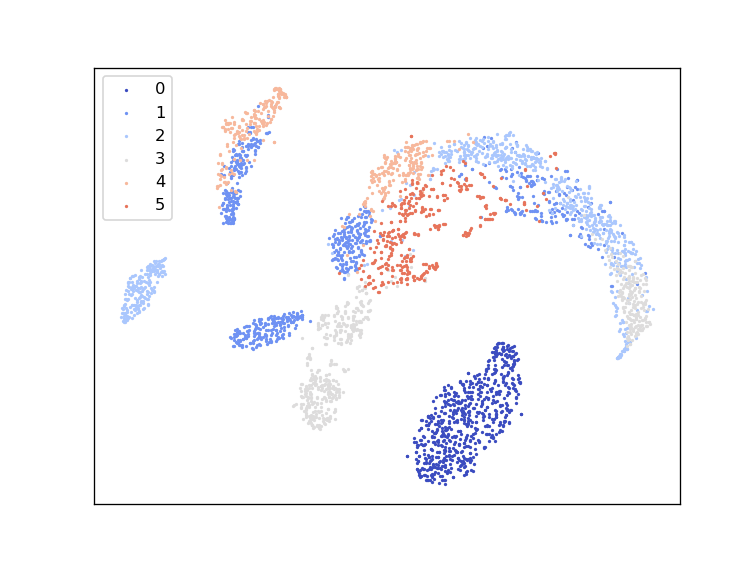

In [34]:
%matplotlib notebook
draw_plot(z_tsne, label=testY, legend=True)

<IPython.core.display.Javascript object>


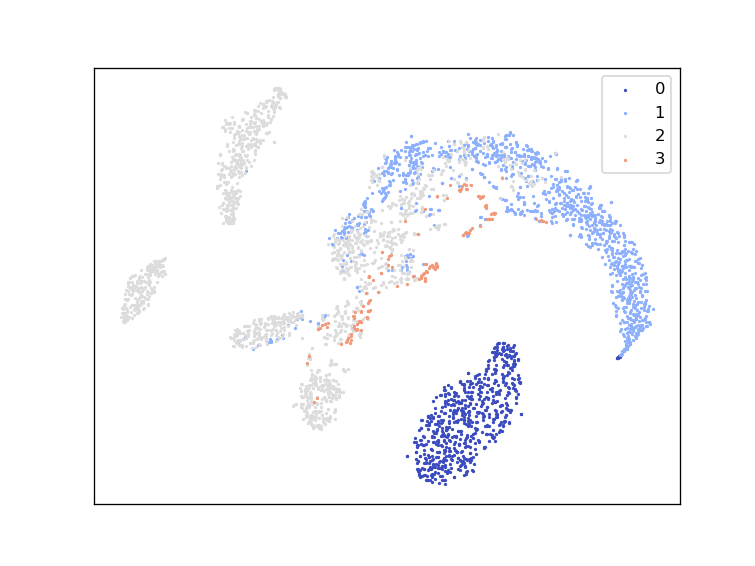

In [35]:
%matplotlib notebook
draw_plot(z_tsne, label=preds, legend=True)

<IPython.core.display.Javascript object>


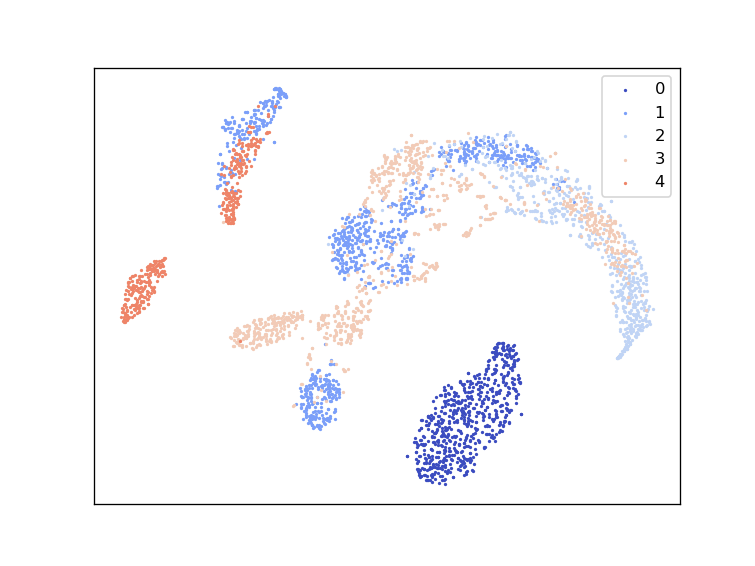

In [36]:
%matplotlib notebook
draw_plot(z_tsne, label=test_diameter, legend=True)

<IPython.core.display.Javascript object>


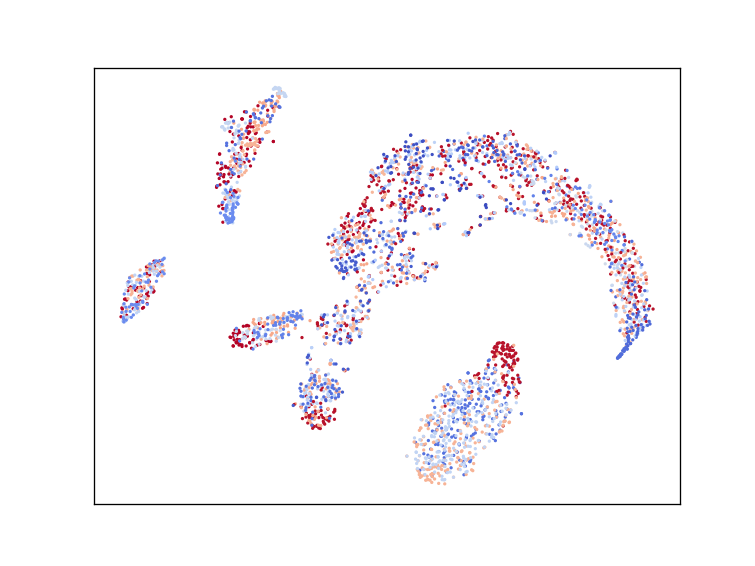

In [37]:
%matplotlib notebook
draw_plot(z_tsne, label=test_rpm)

In [38]:
def draw_magic(tsne, label, raw, index, cmap = None, frame_len=1024, frame_intv=512):
    global p, m,pick
    p=None
    fig=plt.figure(figsize=(8,8))
    ax0 = plt.subplot2grid((4,1),(0,0),rowspan=3)#(3,1,1)
    ax1 = plt.subplot(414)
    
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax1.set_xticks([])
    ax1.set_yticks([])
    
    m=0
    pick=False
    text = ax0.text(0,100,"Label %d"%m,va='top',ha='left')
    def onpress(event):
        global m,pick
        if event.key=='right' and m < len(label)-1:
            m+=1
        elif event.key == 'left' and m > 0:
            m-=1
        else:
            return
        if pick:
            p.remove()
            pick=False
        ax0.cla()
        ax0.set_xticks([])
        ax0.set_yticks([])
        text = ax0.text(0,100,"Label %d"%m,va='top',ha='left')
        draw_plot(tsne, label[m], cmap, legend=False, ax=ax0)
        fig.canvas.draw()
        
    def onpick(event):
        global p,pick
        pt = event.ind[0]
        if pick:
            p.remove()
            pick=False
        p = ax0.scatter(tsne[pt,0],tsne[pt,1],marker='x',s=10,c='k')
        pick=True
        
        ax1.cla()
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax1.plot(raw[index[pt]:index[pt]+frame_len][:,0])
        fig.canvas.draw()
        
    cid = fig.canvas.mpl_connect('pick_event', onpick)
    cid2 = fig.canvas.mpl_connect('key_press_event', onpress)
    draw_plot(tsne, label[m], cmap, legend=False, ax=ax0)
    plt.show()

<IPython.core.display.Javascript object>


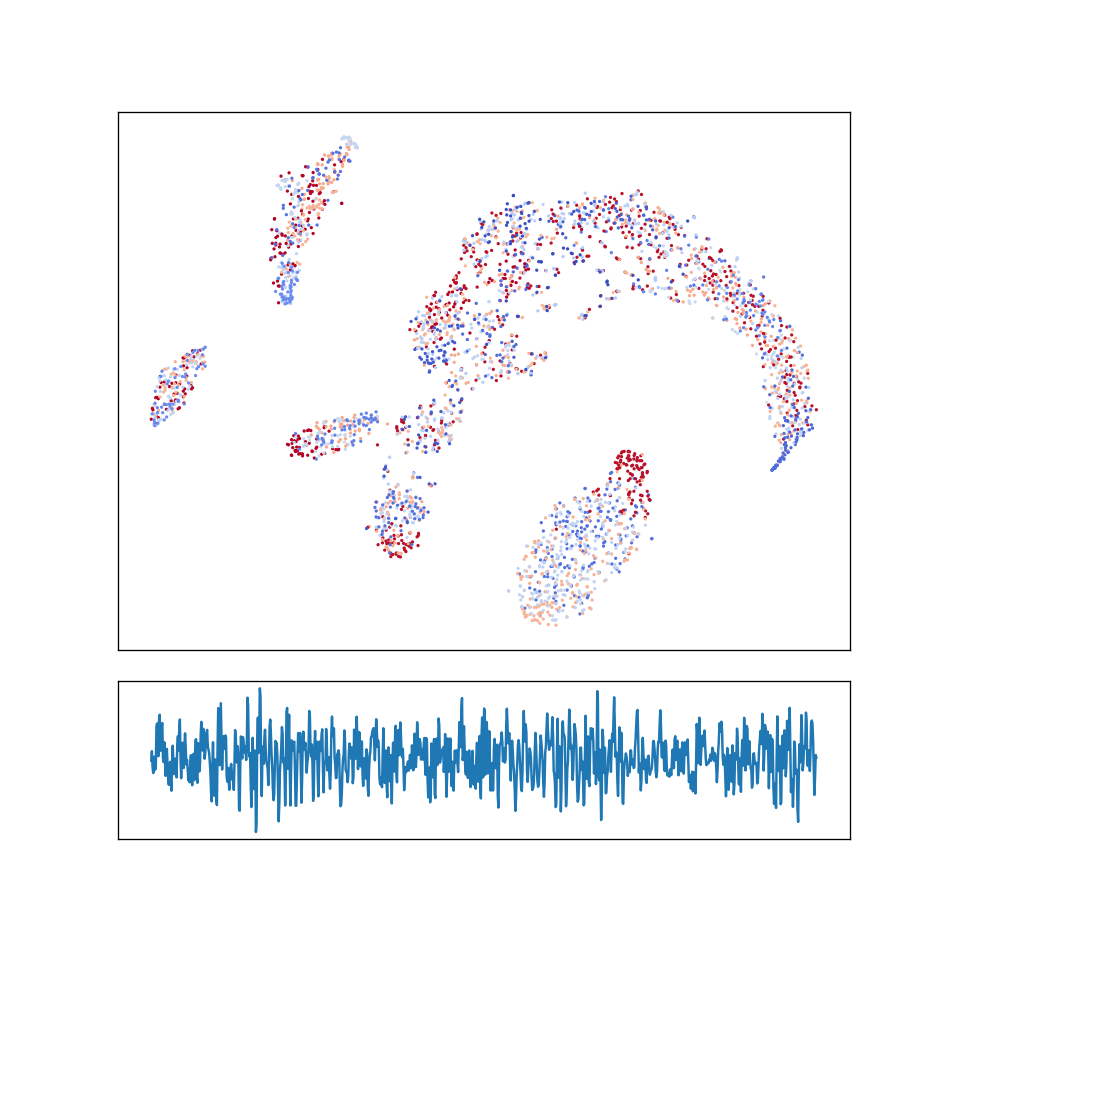

In [39]:
%matplotlib notebook
draw_magic(z_tsne, [preds, testY, test_diameter, test_rpm], DATA, test_idx, frame_len=FRAME_LEN, frame_intv=FRAME_INTV)

## 4. Semisupervised Learning!!!!

### 4.1 Mask Definition
let's mask & screen some combination

In [40]:
MASK_P = 0.005
SCREEN_DIAM = 2

In [41]:
from src.utils.data_utils import show_table
SEED=0
np.random.seed(SEED)
while True:
    MASK = np.array([False]*trainY.shape[0])
    l_temp = len(MASK[(train_diameter!=SCREEN_DIAM)])
    MASK[(train_diameter!=SCREEN_DIAM)] = np.random.choice(l_temp, l_temp, replace=False) < int(MASK_P*trainY.shape[0])
    if set([0,1,2,3,4,5]).issubset(set(trainY[MASK])):
        print('SEED : %d'%SEED)
        break
    SEED+=1
    np.random.seed(SEED)
print("# of labeled data : %d"%MASK.sum())
print('# of unlabeled data : %d'%(MASK.shape[0]-MASK.sum()))
print('percentage : %.2f%%'%(100*MASK.sum()/MASK.shape[0]))

show_table(MASK, trainY, train_diameter, average=False)

SEED : 0
# of labeled data : 69
# of unlabeled data : 13897
percentage : 0.49%


		0	1	2	3	4	5	| total
0"	|	14	-	-	-	-	-	| 14
0.007"	|	-	5	4	4	6	3	| 22
0.14"	|	-	0	0	0	-	-	| 0
0.021"	|	-	2	5	5	6	5	| 23
0.028"	|	-	6	4	-	-	-	| 10
------------------------------------------------------------------------
total	|	14	13	13	9	12	8	| 69


### 4.2 Training
naive supervised learning with only labels given

In [42]:
model = SimpleModel()
model.cuda()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [43]:
train_shuffle = np.arange(train_idx.shape[0])
np.random.shuffle(train_shuffle)
train_shuffle, val_shuffle = np.split(train_shuffle, [4*train_shuffle.shape[0]//5])
print(train_idx.shape, train_shuffle.shape, val_shuffle.shape)

(13966,) (11172,) (2794,)


In [44]:
TRAIN_PARAMS = {
    'model' : model,
    'optimizer' : optimizer,
    'train_idx' : train_idx,
    'trainY' : trainY,
    'data' : DATA,
    'model_name' : 'tutorial_semi',
    'train_shuffle' : train_shuffle,
    'val_shuffle' : val_shuffle,
    'mask' : MASK,
    'sav_intv' : SAV_INTV,
    'tol' : TOL,
    'sav_path' : SAVE_PATH,
    'epoch' : EPOCH,
    'batch' : BATCH,
    'frame_len' : FRAME_LEN,
    'batch_step' : batch_step
}

In [63]:
#train(model, optimizer, trainY, 'tutorial_semi', mask=MASK)
train(**TRAIN_PARAMS)

(1.39s)[Epoch 1]
	(train) loss : 0.95075,	acc : 0.21661
	(eval) loss : 0.97977,	acc : 0.20795
(1.33s)[Epoch 2]
	(train) loss : 0.92500,	acc : 0.22216
	(eval) loss : 0.98790,	acc : 0.28848


KeyboardInterrupt: 

### 4.3 Testing
test

In [45]:
TEST_PARAMS = {
    'model' : model,
    'test_idx' : test_idx,
    'testY' : testY,
    'data' : DATA,
    'model_name' : 'tutorial_semi',
    'load_version' : 'best',
    'sav_path' : SAVE_PATH,
    'batch' : BATCH,
    'frame_len' : FRAME_LEN,
    'batch_step' : batch_step
}

In [46]:
test(**TEST_PARAMS)

Test Result of model <tutorial_semi>:best
  [Loss]	1.77641
  [Accuracy]	21.76%


In [47]:
score_table(diameter = test_diameter, **TEST_PARAMS)



		0	1	2	3	4	5	| total
0"	|	0.0	-	-	-	-	-	| 0.0
0.007"	|	-	1.0	0.0	0.0	0.0	0.0	| 0.199
0.14"	|	-	1.0	0.0	0.0	-	-	| 0.333
0.021"	|	-	1.0	0.0	0.020	0.0	0.0	| 0.204
0.028"	|	-	1.0	0.0	-	-	-	| 0.502
------------------------------------------------------------------------
total	|	0.0	1.0	0.0	0.006	0.0	0.0	| 0.217


<IPython.core.display.Javascript object>


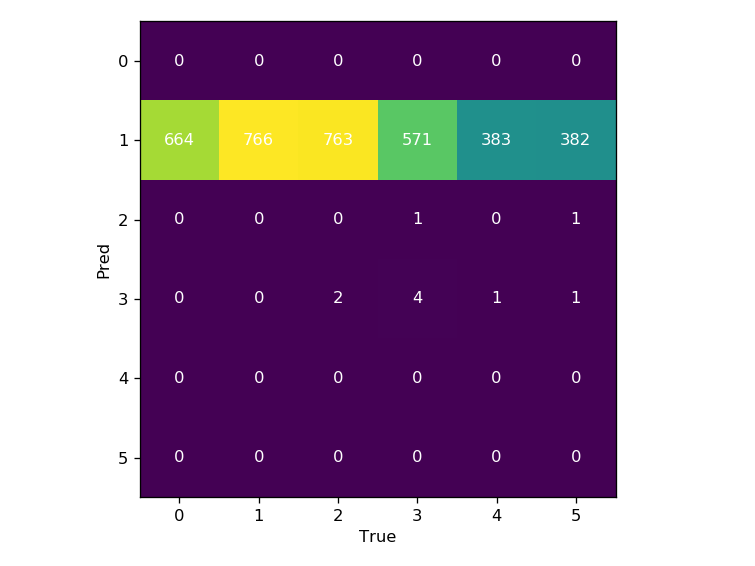

In [48]:
%matplotlib notebook
confusion_matrix(**TEST_PARAMS)

low score, tsne of train&unlabeled+test data

make your own model for semisupervised learning on Project.ipynb

In [49]:
z, preds = get_latents(**TEST_PARAMS)
z = z.cpu().numpy()
preds = preds.cpu().numpy()
print(z.shape, preds.shape)

(3539, 32) (3539,)


In [50]:
tsne = TSNE(n_components=2)
z_tsne = tsne.fit_transform(z)
print(z_tsne.shape)

(3539, 2)


<IPython.core.display.Javascript object>


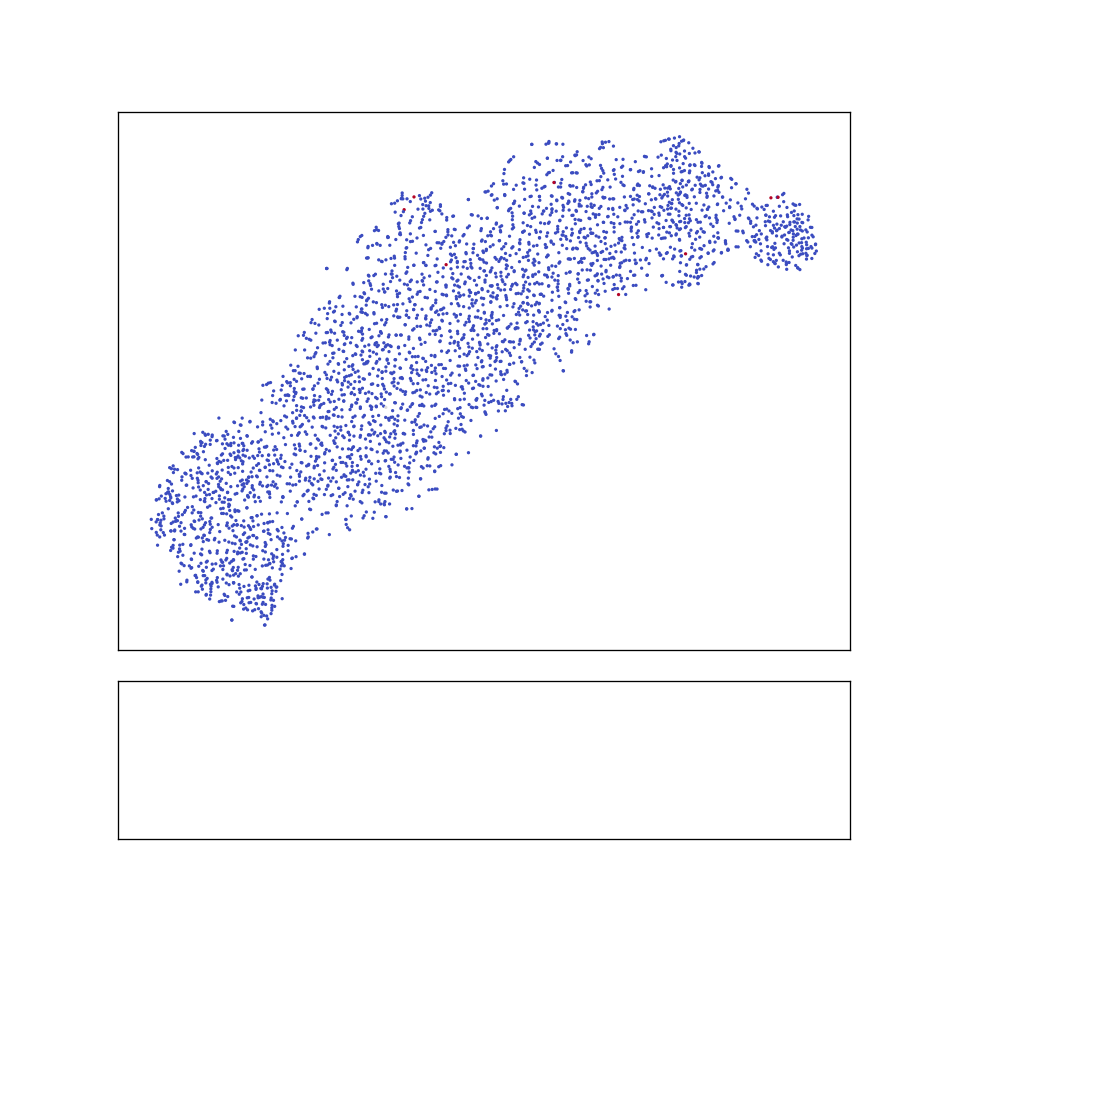

In [51]:
%matplotlib notebook
draw_magic(z_tsne, [preds, testY, test_diameter, test_rpm], DATA, test_idx, frame_len=FRAME_LEN, frame_intv=FRAME_INTV)

In [52]:
TEST_PARAMS = {
    'model' : model,
    'data' : DATA,
    'model_name' : 'tutorial_semi',
    'load_version' : 'best',
    'sav_path' : SAVE_PATH,
    'batch' : BATCH,
    'frame_len' : FRAME_LEN,
    'batch_step' : batch_step
}

In [53]:
test(**TEST_PARAMS, test_idx = train_idx, testY = trainY)

Test Result of model <tutorial_semi>:best
  [Loss]	1.77646
  [Accuracy]	21.62%


In [54]:
test(**TEST_PARAMS, test_idx=train_idx[MASK], testY=trainY[MASK])

Test Result of model <tutorial_semi>:best
  [Loss]	1.77680
  [Accuracy]	18.84%


In [55]:
test(**TEST_PARAMS, test_idx=train_idx[~MASK], testY=trainY[~MASK])

Test Result of model <tutorial_semi>:best
  [Loss]	1.77646
  [Accuracy]	21.64%


In [56]:
z_train, preds_train = get_latents(**TEST_PARAMS, test_idx=train_idx, testY=trainY)
z_train = z_train.cpu().numpy()
preds_train = preds_train.cpu().numpy()

In [57]:
tsne = TSNE(n_components=2)
z_tsne_train = tsne.fit_transform(z_train)
print(z_tsne_train.shape)

(13966, 2)


<IPython.core.display.Javascript object>


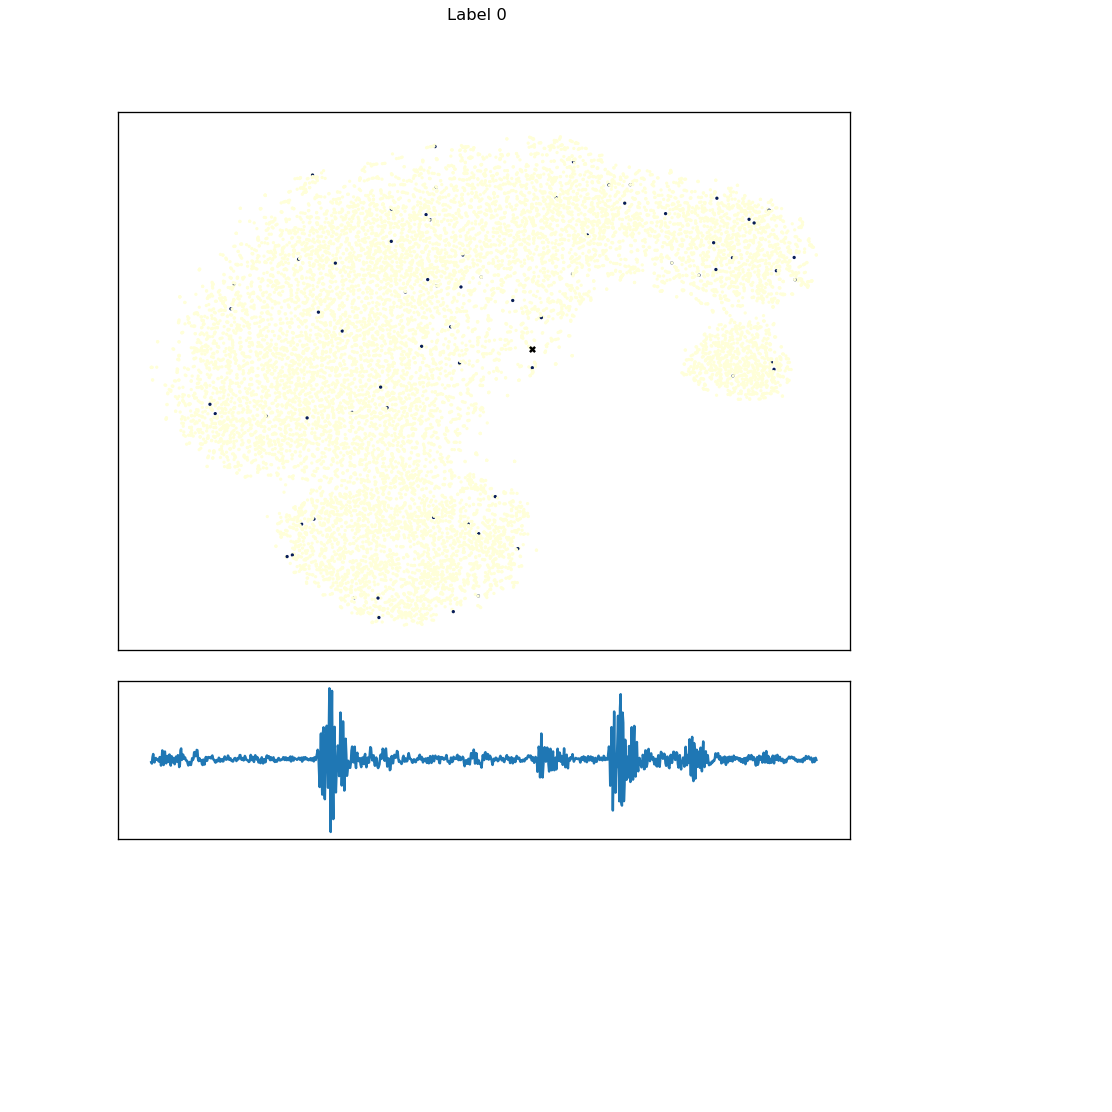

In [58]:
%matplotlib notebook
draw_magic(z_tsne_train, [MASK,preds_train, trainY, train_diameter, train_rpm], DATA, train_idx, frame_len=FRAME_LEN, frame_intv=FRAME_INTV, cmap='YlGnBu')